In [4]:
import tifffile as tiff
import numpy as np
from cellpose import models
from cellpose import plot
from cellpose import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import cv2
import pandas as pd
import os

# Specify a single sample file
sample_file = "example2_A1_zoom.tiff"

# Load image
image = tiff.imread(sample_file)

# Define the model (TN3 model recommended)
model = models.CellposeModel(gpu=False, model_type='TN3')

# Run the cellpose model
masks, flows, styles = model.eval(image, diameter=23, channels=[2, 3], flow_threshold=0.4)

# Count number of cells
num_cells = len(np.unique(masks)) - 1
print(f"Number of cells detected in {sample_file}: {num_cells}")


Number of cells detected in example2_A1_zoom.tiff: 535


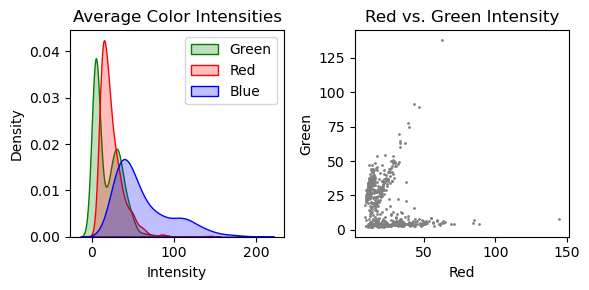

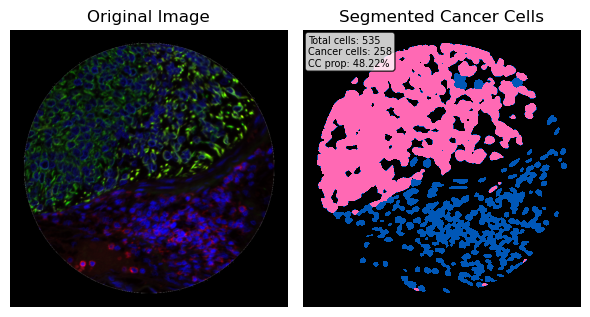

Processed example2_A1_zoom.tiff


In [5]:
# Function to extract intensities and calculate features
def extract_intensities_and_plot(image, masks):
    green_channel = image[:, :, 1]
    red_channel = image[:, :, 0]
    blue_channel = image[:, :, 2]
    
    green_intensities = []
    red_intensities = []
    blue_intensities = []
    Npis = []
    perimeters = []
    areas = []
    circularities = []
    
    unique_cells = np.unique(masks)
    for cell_id in unique_cells:
        if cell_id == 0:
            continue
        
        green_cell_region = green_channel[masks == cell_id]
        red_cell_region = red_channel[masks == cell_id]
        blue_cell_region = blue_channel[masks == cell_id]
        
        green_avg_intensity = np.mean(green_cell_region)
        red_avg_intensity = np.mean(red_cell_region)
        blue_avg_intensity = np.mean(blue_cell_region)
        
        Npi = np.sum(masks == cell_id)
        
        cell_mask = (masks == cell_id).astype(np.uint8)
        contours, _ = cv2.findContours(cell_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        perimeter = cv2.arcLength(contours[0], True)
        area = cv2.contourArea(contours[0])
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
        
        green_intensities.append(green_avg_intensity)
        red_intensities.append(red_avg_intensity)
        blue_intensities.append(blue_avg_intensity)
        Npis.append(Npi)
        perimeters.append(perimeter)
        areas.append(area)
        circularities.append(circularity)
    
    return green_intensities, red_intensities, blue_intensities, Npis, perimeters, areas, circularities

# Extract data
green_intensities, red_intensities, blue_intensities, Npis, perimeters, areas, circularities = extract_intensities_and_plot(image, masks)

# Convert to DataFrame
cell_stat = pd.DataFrame({
    'R_Int': red_intensities,
    'G_Int': green_intensities,
    'B_Int': blue_intensities,
    'Pixels': Npis,
    'Perimeter': perimeters,
    'Area': areas,
    'Circularity': circularities
})

# Save intensity visualization
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
sns.kdeplot(green_intensities, label='Green', fill=True, color='g')
sns.kdeplot(red_intensities, label='Red', fill=True, color='r')
sns.kdeplot(blue_intensities, label='Blue', fill=True, color='b')
plt.xlabel('Intensity')
plt.ylabel('Density')
plt.legend()
plt.title('Average Color Intensities')

plt.subplot(1, 2, 2)
plt.scatter(red_intensities, green_intensities, c='gray', marker='o', s=1)
plt.xlabel('Red')
plt.ylabel('Green')
plt.title('Red vs. Green Intensity')
plt.tight_layout()
plt.savefig(f"{sample_file}.int.pdf", format="pdf")
plt.show()

# Function to visualize segmented cells
def mark_and_visualize_cells(image, masks):
    green_channel = image[:, :, 1]
    unique_cells = np.unique(masks)
    marked_mask = np.zeros_like(masks)
    
    cancer_cells_count = 0
    total_cells_count = 0

    for cell_id in unique_cells:
        if cell_id == 0:
            continue
        total_cells_count += 1
        cell_region = green_channel[masks == cell_id]
        avg_intensity = np.mean(cell_region)
        
        if avg_intensity > 15:
            marked_mask[masks == cell_id] = 2
            cancer_cells_count += 1
        else:
            marked_mask[masks == cell_id] = 1
    
    from matplotlib.colors import ListedColormap
    max_value = np.max(marked_mask)
    if max_value == 1:
        custom_cmap = ListedColormap(['black', '#0057b7'])
    else:
        custom_cmap = ListedColormap(['black', '#0057b7', '#ff69b4'])
    
    fig, ax = plt.subplots(1, 2, figsize=(6, 4))
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title('Original Image')
    
    ax[1].imshow(image)
    ax[1].imshow(marked_mask, cmap=custom_cmap, alpha=1)
    ax[1].axis('off')
    ax[1].set_title('Segmented Cancer Cells')
    
    text_str = (
        f"Total cells: {total_cells_count}\n"
        f"Cancer cells: {cancer_cells_count}\n"
        f"CC prop: {cancer_cells_count / total_cells_count:.2%}"
    )
    ax[1].text(0.02, 0.98, text_str, transform=ax[1].transAxes, fontsize=7,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(f"{sample_file}.seg.pdf", format="pdf")
    plt.show()

mark_and_visualize_cells(image, masks)
print(f"Processed {sample_file}")
